Modeling Complex Time Series 

Identifying a stationary ARMA process 

we will use the following simulation to simulate an ARMA (1,1) process:
   yt = 0.33yt –1 + 0.9ϵt –1 + ϵt  to demonstrate that we cannot use the ACF plot to identify the order q or p of an ARMA(p,q) process.

In [1]:
from statsmodels.tsa.arima_process import ArmaProcess 

import numpy as np

np.random.seed(42)

ar1= np.array([1, -0.33]) #first coefficient is always 1, we write the coefficient of AR with an opposite sign, as specified by the documentation
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [2]:
from statsmodels.tsa.stattools import adfuller 

ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

#stationary process 

ADF Statistic: -6.429878682042698
p-value: 1.707846668009623e-08


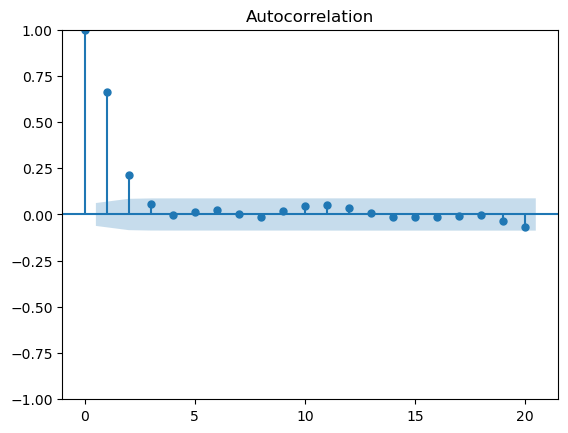

In [3]:
#plot ACF and see if we can infer the order of the MA portion in the ARMA model
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ARMA_1_1, lags=20)

plt.show()

Sinusoidal pattern observed indicating an autoregressive process. No significant info on order q since the lats significant coefficient is seen at lag 2 yet the simulated process is ARMA (1,1). Let's plot PACF

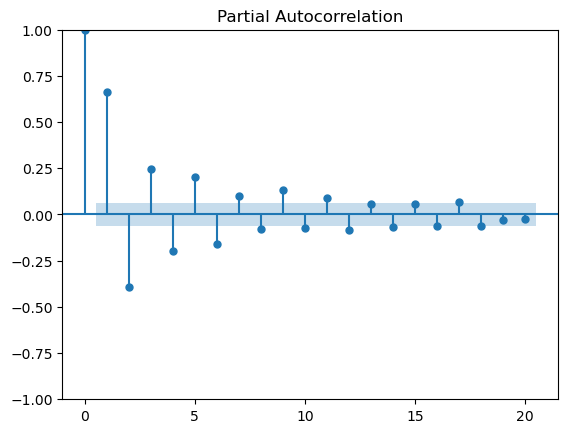

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ARMA_1_1, lags=20)

plt.show()

Clear sinusoidal pattern observed. Significant coefficients past lag 1 seen, thus no value can be determined from this plot.

Selecting a Model using the AIC 

In [5]:
from itertools import product

ps= range(0,4,1) #a list of possible values of p, starting from 0(inclusive) to 4(exclusive), with a step of 1

qs = range(0,4,1)

order_list = list(product(ps, qs)) #generate a list of all unique combinations of p and q values


In [6]:
#create a function to fit all unique ARMA(p,q) models
import pandas as pd
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list:list) -> pd.DataFrame:
    results =  [] #empty list to store the order (p,q)  and the corresponding AIC as a tuple
    for order in tqdm_notebook(order_list): #progress bar, iterate over each unique (p,q) combination
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_dfferencing= False).fit(disp=False)
        except:
            continue
        aic = model.aic #calculate the model's AIC 
        results.append([order, model.aic]) #append the order (p,q) and the corresponding AIC as a tuple to the results list

    result_df = pd.DataFrame(results) #convert the results list to a dataframe
    result_df.columns = ['(p,q)', 'AIC'] #label the columns

    #sort the dataframe by ascending AIC
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [7]:
result_df = optimize_ARMA(ARMA_1_1, order_list)

result_df

C:\Users\user\AppData\Local\Temp\ipykernel_11484\3176498861.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list): #progress bar, iterate over each unique (p,q) combination


  0%|          | 0/16 [00:00<?, ?it/s]

c:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['simple_dfferencing']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2805.947247
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


The lower the AIC, the better themodel. Thus ARMA(1,1) is the best relative to all other models. 

Residual Analysis 

In [8]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_dfferencing= False) 
model_fit = model.fit(disp=False)
residuals = model_fit.resid #store the model's residuals

c:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['simple_dfferencing']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


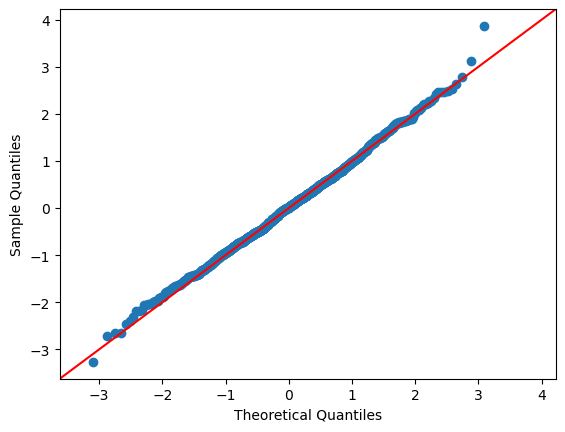

In [9]:
#plot the Q-Q plot
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='45')

plt.show()


from a qualitative pov, the residuals seem to be normally distributed just like white noise, meaning our model fits the data well.

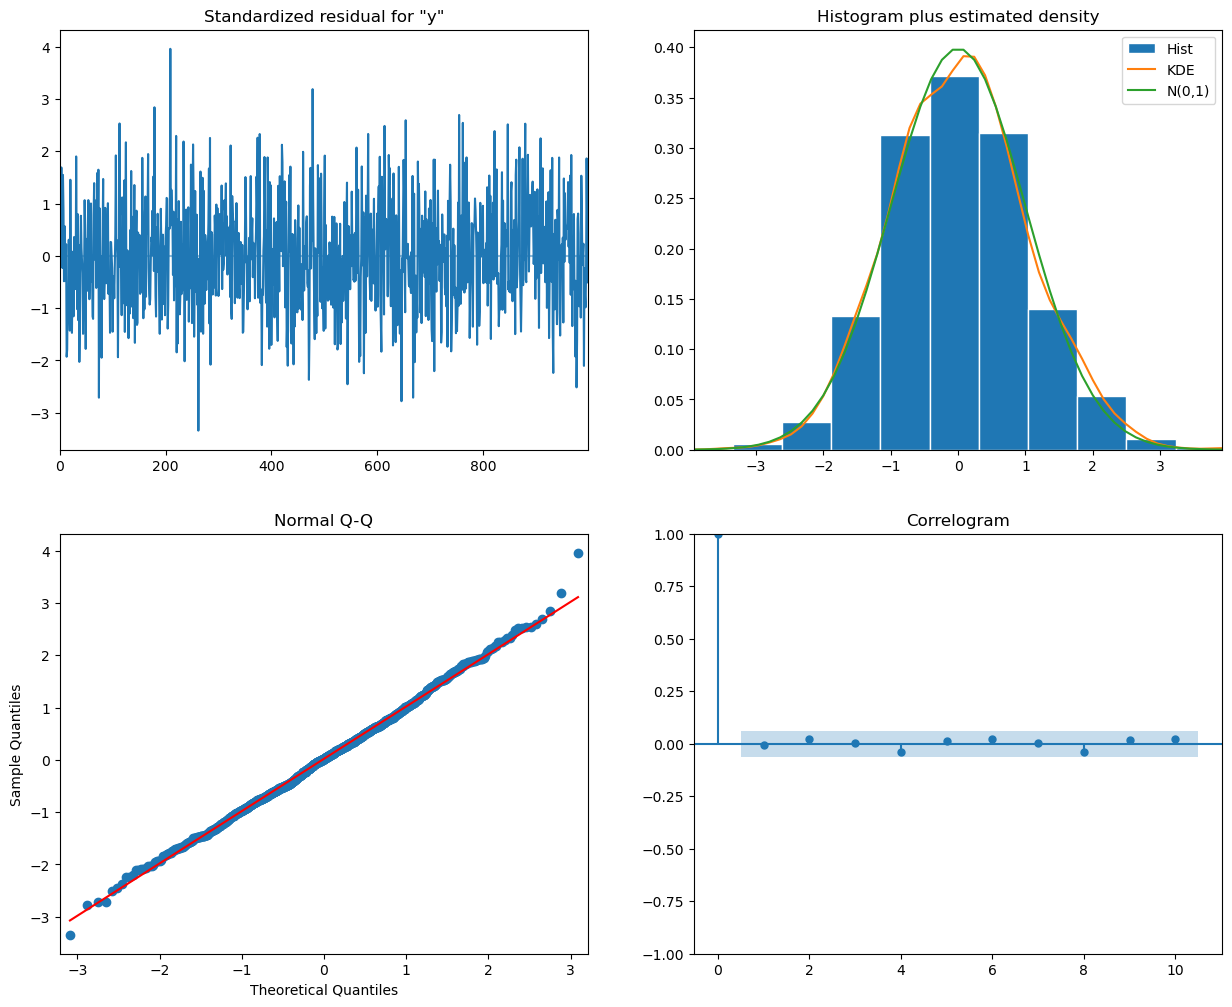

In [10]:
model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [12]:
#Apply the Ljung-Box test on the residuals 

from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags = 10, return_df=True)

lb_test

,lb_stat,lb_pvalue
1,0.030706,0.860897
2,0.528021,0.767966
3,0.540904,0.909817
4,2.079774,0.721089
5,2.271897,0.810385
6,2.896262,0.821750
7,2.900378,0.894063
8,4.418799,0.817501
9,4.787567,0.852419
10,5.246805,0.874093


Applying the General Modeling Procedure 

In [14]:
df = pd.read_csv(r"C:\Users\user\Downloads\bandwidth.csv")
df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


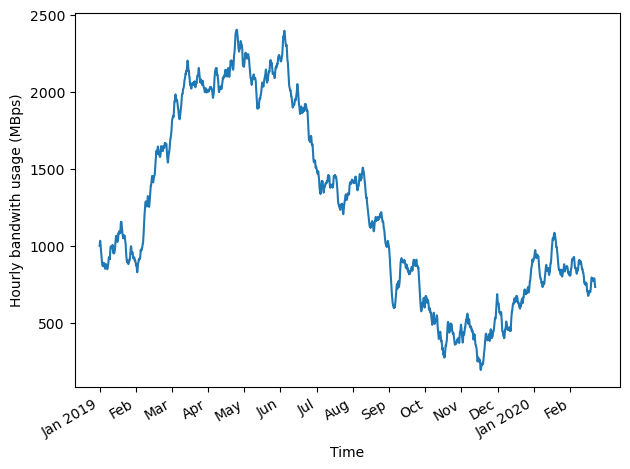

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

>   No periodic data pattern observed, hwever the long-term trend could mean our data is not stationary

In [19]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8714653199452932
p-value: 0.7972240255014489


In [22]:
#apply transformation
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1) 

In [23]:
ADF_result = adfuller(bandwidth_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.69485386378901
p-value: 0.0


After converting our data to stationary data, we can now model the process using ARMA(p,q) model

Split data to train and test sets

Our forecasts are for the next 2hours, the test thus has 84 periods of 2 hours to evaluate the model's performance. The last 7 days of data are set aside to be the test set

In [26]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:] #168 hours in a week, the last 168 are assigned to the test set

print(len(train))
print(len(test))

9831
168


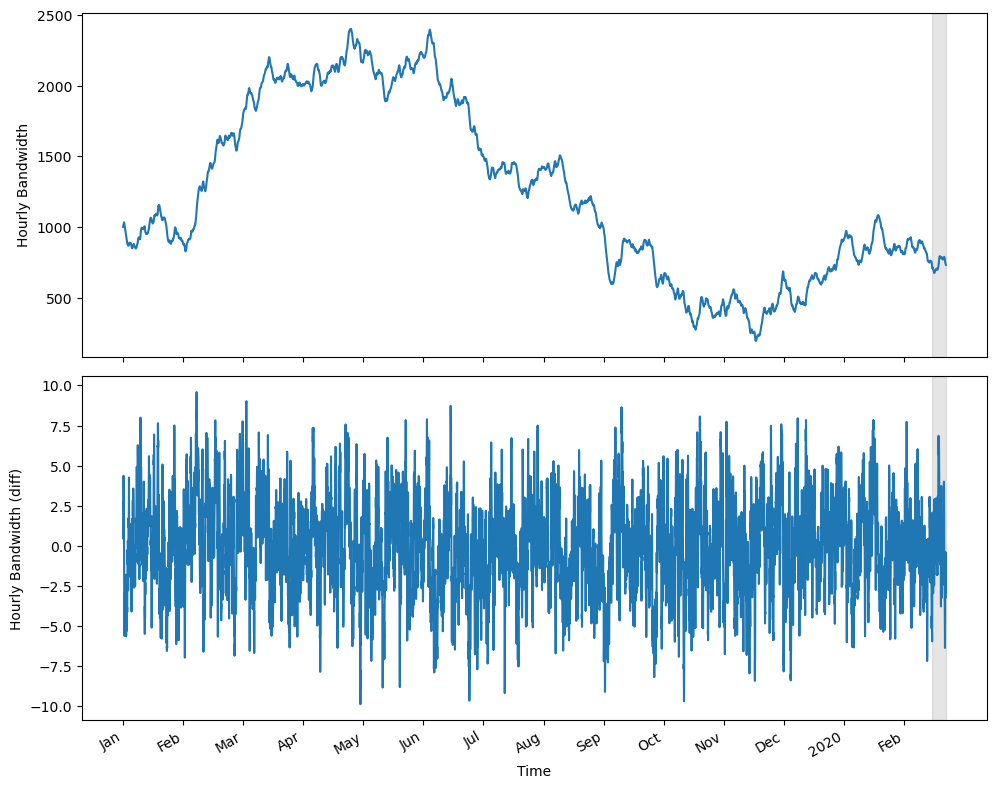

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(df.hourly_bandwidth)
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly Bandwidth')
ax1.axvspan(9831,10000,color='grey',alpha= .2)

ax2.plot(df_diff.bandwidth_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly Bandwidth (diff)')
ax2.axvspan(9830,9999,color='grey',alpha= .2)

plt.xticks(
    np.arange(0,10000,730),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

>   Our train set is ready, and we can now fit different ARMA(p,q) models using the optimize_
ARMA function that we defined earlier.

>   The function takes the data and the list of unique (p,q) combinations as input. Inside the function, we initialize an empty list to store each (p,q) combination and its corresponding AIC.

>   Then we iterate over each (p,q) combination and fit an ARMA(p,q) model on our data,compute
the AIC and store the result. Then we create a DataFrame and sort it by AIC value in ascending order, since the lower the AIC, the better the model. 

Our function finally outputs the ordered DataFrame so we can select the appropriate model.

In [33]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list:list) -> pd.DataFrame:
    results =  [] #empty list to store the order (p,q)  and the corresponding AIC as a tuple
    for order in tqdm_notebook(order_list): #progress bar, iterate over each unique (p,q) combination
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing= False).fit(disp=False)
        except:
            continue
        aic = model.aic #calculate the model's AIC 
        results.append([order,aic]) #append the order (p,q) and the corresponding AIC as a tuple to the results list

    result_df = pd.DataFrame(results) #convert the results list to a dataframe
    result_df.columns = ['(p,q)','AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df 

In [34]:
ps = range(0,4,1)
qs = range(0,4,1)

order_list = list(product(ps,qs))

In [35]:
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)

result_df

C:\Users\user\AppData\Local\Temp\ipykernel_11484\3049559723.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list): #progress bar, iterate over each unique (p,q) combination


  0%|          | 0/16 [00:00<?, ?it/s]

c:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


Select the ARMA(2,2) model since its AIC is closer to that of ARMA(2,3) AND (3,2) models yet it is less complex due to less parameters.

Residual analysis 

In [37]:
#model fitting
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing= False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13990.802
Date:                Thu, 11 Jul 2024   AIC                          27991.604
Time:                        11:06:51   BIC                          28027.570
Sample:                             0   HQIC                         28003.788
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

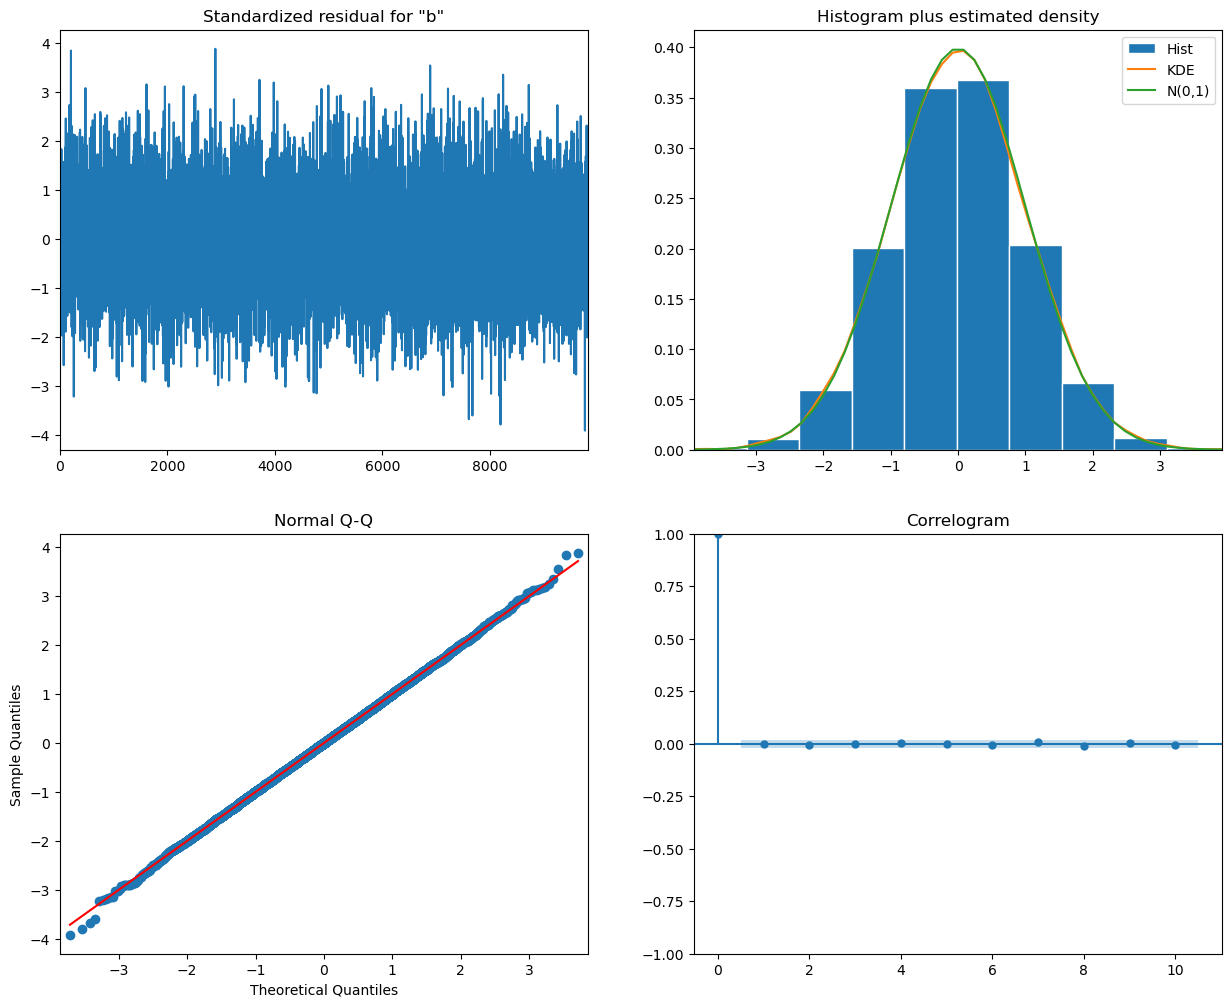

In [39]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [43]:
#Ljung-Box test

residuals = model_fit.resid

lb_test = acorr_ljungbox(residuals, lags=10)

lb_test



,lb_stat,lb_pvalue
1,0.042190,0.837257
2,0.418364,0.811247
3,0.520271,0.914416
4,0.850555,0.931545
5,0.850841,0.973678
6,1.111754,0.981019
7,2.124864,0.952607
8,3.230558,0.919067
9,3.248662,0.953615
10,3.588289,0.964015


The returned p-values all exceed 0.05. We can conclude that our residualsare indeed uncorrelated. Our ARMA(2,2) model has passed all the checks on the residual analysis, and we are ready to use this model to forecast bandwidth usage

Forecasting Bandwidth Usage 

In [46]:
def rolling_forecast(df: pd.DataFrame, train_len:int, horizon:int, window:int, method:str)->list:
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last_value =[]

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value

    elif method =='ARMA':
        pred_ARMA =[]
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order =(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i+window-1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)

        return pred_ARMA

In [48]:
pred_def = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')

pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')

pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

C:\Users\user\AppData\Local\Temp\ipykernel_11484\2905553918.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = pred_mean
C:\Users\user\AppData\Local\Temp\ipykernel_11484\2905553918.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_value'] = pred_last_value
C:\Users\user\AppData\Local\Temp\ipykernel_11484\2905553918.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,bandwidth_diff,pred_mean,pred_last_value,pred_ARMA
9831,-5.943995,-0.028214,-5.791207,-5.460661
9832,-5.865194,-0.028214,-5.791207,-4.890626
9833,-3.197066,-0.029410,-5.865194,-5.335905
9834,-1.090197,-0.029410,-5.865194,-4.751731
9835,0.665291,-0.029840,-1.090197,-0.375596


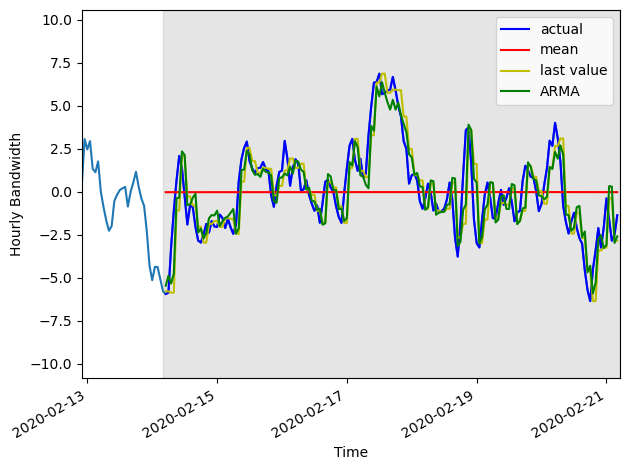

In [49]:
fig, ax = plt.subplots()
ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['bandwidth_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'r-', label='mean')
ax.plot(test['pred_last_value'], 'y-', label='last value')
ax.plot(test['pred_ARMA'], 'g-', label='ARMA')
ax.legend(loc='best')

ax.set_xlabel('Time')
ax.set_ylabel('Hourly Bandwidth')
ax.axvspan(9830,9999,color='grey',alpha= .2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])



fig.autofmt_xdate()
plt.tight_layout()

In [50]:
#Measure MSE to evaluate the models

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])

mse_last = mean_squared_error(test['bandwidth_diff'],test['pred_last_value'])

mse_ARMA = mean_squared_error(test['bandwidth_diff'],test['pred_ARMA'])

print(mse_mean)
print(mse_last)
print(mse_ARMA)

6.306526957989325
2.2297582947733656
1.7690462114248693


Final step is to reverse the transformation of our forecast in order to bring it to
the same scale as our original data.

Remember that we differenced the original data to make it stationary. The ARMA(2,2) model was then applied on the stationary dataset and produced forecasts that are differenced.

To reverse the differencing transformation, we can apply a cumulative sum

In [55]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()

C:\Users\user\AppData\Local\Temp\ipykernel_11484\437219497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()


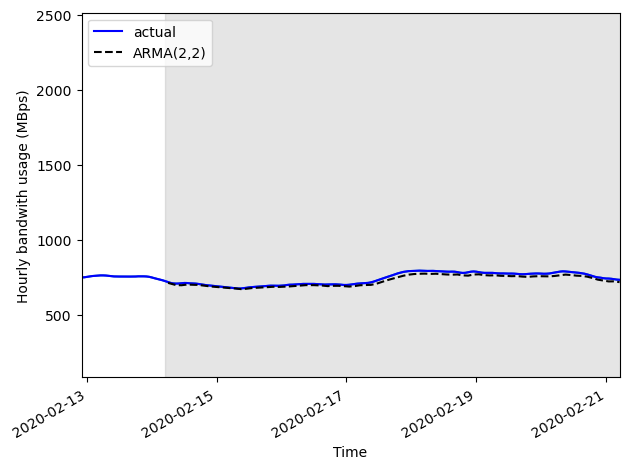

In [56]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

ax.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

In [58]:
from sklearn.metrics import mean_absolute_error

mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])

print(mae_ARMA_undiff)

14.000362773714626


On average, our forecasts are 14 Mbps above or below the actual bandwidth usage.